Trained models for cell detection can be downloaded from https://drive.google.com/drive/folders/1dVHZQaauw85QrXi_C6rBQrKg0n8y4gWA?usp=sharing

### Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

import sys
sys.path.insert(0, '../')

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

Using TensorFlow backend.


### Load RetinaNet models

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path_single = os.path.join('snapshots', 'resnet50_csv_50_cell.h5')
model_path_cluster = os.path.join('snapshots', 'resnet50_csv_50_cluster.h5')

# load retinanet model
model_single = models.load_model(model_path_single, backbone_name='resnet50')
model_cluster = models.load_model(model_path_cluster, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model_single = models.convert_model(model_single)
model_cluster = models.convert_model(model_cluster)

# print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {1: 'yellow neuron', 2: 'yellow glia', 
                   3: 'green neuron', 4: 'green glia', 5: 'red neuron',
                   6: 'red glia', 7: 'glia cluster'}


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

### Merge inferences and visualize

processing time:  0.562546968460083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


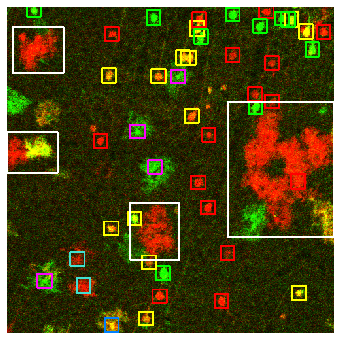

In [4]:
# load image
image = read_image_bgr('./images/example_img_001.tif')

CAPTION = False

# copy to draw on
draw = image.copy()/255 # RGB to save

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_single.predict_on_batch(np.expand_dims(image, axis=0))
boxes_cluster, scores_cluster, labels_cluster = model_cluster.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale
boxes_cluster /= scale

# set thresholds
THRE = 0.5 # threshold for score - individual cell
THRE_C = 0.3 # threshold for score - glia cluster

# (temp) save all predicted clusters above THRE_C
predict_clusters = []
for c in range(len(scores_cluster[0])):
    if scores_cluster[0,c] < THRE_C:
        break
    bc = boxes_cluster[0,c].astype(int)
    predict_clusters.append((bc[0], bc[1], bc[2], bc[3], 
                                scores_cluster[0,c], 7))

# save all predicted clusters w/ confidence above 0.5
detect_clusters_temp = []
for c in range(len(predict_clusters)):
    if predict_clusters[c][4] < 0.5:
        break
    detect_clusters_temp.append(predict_clusters[c])
l = len(detect_clusters_temp)

# (temp) save all predicted glias above THRE
predict_glias = []
for g in range(len(scores[0])):
    if scores[0,g] < THRE:
        break
    if labels[0,g]%2 == 0:
        b = boxes[0,g].astype(int)
        predict_glias.append((b[0], b[1], b[2], b[3],
                              scores[0,g], labels[0,g]))

cluster_ids = {} # id for clusters containing single detections
detect_glias = [] # save single detections of glia
detect_clusters = [] # save cluster detections of glia
n_obj = 0

# merge and visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):

    # scores are sorted so we can break
    if score < THRE:
        break

    # print(box, score, label)

    if label%2 == 1:              
        # neuron    
        n_obj += 1
        color = label_color(label)               
        b = box.astype(int)
        draw_box(draw, b, color=color, thickness=2)

        # save results
        if CAPTION:
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption_custom(draw, b, caption)

    else:
        # glia
        in_cluster = False
        b = box.astype(int)
        map_s = np.zeros((500,500), dtype=float)
        map_s[b[0]:b[2], b[1]:b[3]] = 1
        # check if in a cluster detection above 0.5
        for c in range(len(predict_clusters)):
            x1, y1, x2, y2, score_c, label_c = predict_clusters[c]
            if score_c < 0.5:
                break
            map_c = np.zeros((500,500), dtype=float)
            map_c[x1:x2, y1:y2] = 1
            iosc = ((map_s>0)*(map_c>0)).sum()/(map_s>0).sum()
            if iosc > 0.5:
                # in a cluster (> 0.5)
                in_cluster = True
                predict_clusters[c] = (min(x1,b[0]), min(y1,b[1]), 
                                       max(x2,b[2]), max(y2,b[3]), 
                                       score_c, label_c)
                if not c in cluster_ids:
                    cluster_ids[c] = 0
                else:
                    cluster_ids[c] += 1
                break

        if not in_cluster:
            # check if there are overlapped glia detections
            for g in range(len(predict_glias)):
                x1, y1, x2, y2, score_g, label_g = predict_glias[g]
                map_g = np.zeros((500,500), dtype=float)
                map_g[x1:x2, y1:y2] = 1
                iosg = ((map_s>0)*(map_g>0)).sum()
                if 0 < iosg < 400:
                    # overlapped by other glia detections
                    # check if in a cluster detection above 0.3
                    for c in range(l,len(predict_clusters)):
                        x1, y1, x2, y2, score_c, label_c = predict_clusters[c]
                        map_c = np.zeros((500,500), dtype=float)
                        map_c[x1:x2, y1:y2] = 1
                        iosc = ((map_s>0)*(map_c>0)).sum()/(map_s>0).sum()
                        if iosc > 0.5:
                            # in a cluster (> 0.3)
                            in_cluster = True
                            predict_clusters[c] = (min(x1,b[0]), min(y1,b[1]), 
                                                   max(x2,b[2]), max(y2,b[3]), 
                                                   score_c, label_c)
                            if not c in cluster_ids:
                                cluster_ids[c] = 0
                            else:
                                cluster_ids[c] += 1
                            break
                    break

            if not in_cluster:
                detect_glias.append((b[0],b[1],b[2],b[3],score,label))

if cluster_ids:  
    for cid in cluster_ids:
        x1, y1, x2, y2, score_c, label_c = predict_clusters[cid]
        if cluster_ids[cid] > 0:
            score_c += 0.05
        score_c = min(score_c, 1.0)
        detect_clusters_temp.append((x1, y1, x2, y2, score_c, label_c))

# remove overlapped clusters
if detect_clusters_temp:
    for c in range(len(detect_clusters_temp)):
        in_cluster = False
        if detect_clusters:
            x1, y1, x2, y2, score_c, label_c = detect_clusters_temp[c]
            map_c = np.zeros((500,500), dtype=float)
            map_c[x1:x2, y1:y2] = 1
            for d in range(len(detect_clusters)):
                x11, y11, x22, y22, score_cc, _ = detect_clusters[d]
                map_d = np.zeros((500,500), dtype=float)
                map_d[x11:x22, y11:y22] = 1
                iocd = ((map_c>0)*(map_d>0)).sum()/min((map_c>0).sum(),(map_d>0).sum())
                if iocd > 0.45:
                    in_cluster = True
                    # keep the bigger cluster
                    detect_clusters[d] = (min(x1,x11), min(y1,y11), 
                                          max(x2,x22), max(y2,y22), 
                                          max(score_c, score_cc), 
                                          label_c)
                    break
        if not in_cluster:
            detect_clusters.append(detect_clusters_temp[c])

# save results for clusters
for c in range(len(detect_clusters)):            
    x1, y1, x2, y2, score_c, label_c = detect_clusters[c]
    n_obj += 1
    bc = np.array([x1, y1, x2, y2])
    color = label_color(label_c)
    draw_box(draw, bc, color=color, thickness=2)

    if CAPTION:
        caption = "{} {:.3f}".format(labels_to_names[label_c], score_c)
        draw_caption(draw, bc, caption)

# remove single glia in clusters
for g in range(len(detect_glias)):

    in_cluster = 0
    x1, y1, x2, y2, score_g, label_g = detect_glias[g]
    b = np.array([x1, y1, x2, y2])

    map_g = np.zeros((500,500), dtype=float)
    map_g[b[0]:b[2], b[1]:b[3]] = 1

    for c in range(len(detect_clusters)):
        x1, y1, x2, y2, score_c, label_c = detect_clusters[c]
        map_c = np.zeros((500,500), dtype=float)
        map_c[x1:x2, y1:y2] = 1
        iogc = ((map_g>0)*(map_c>0)).sum()/(map_g>0).sum()
        if iogc > 0.5:
            in_cluster = 1
            break

    if not in_cluster:
        n_obj += 1
        color = label_color(label_g)

        draw_box(draw, b, color=color, thickness=2)

        if CAPTION:
            caption = "{} {:.3f}".format(labels_to_names[label_g], score_g)
            draw_caption(draw, b, caption)

# visulization
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(draw[:, :, ::-1]/255.)
plt.show()